# load data

In [ ]:
pwd

In [1]:
%matplotlib inline
from netCDF4 import Dataset

import numpy as np
import matplotlib.pyplot as plt
import seaborn

from predictability_utils.utils import helpers, io
from predictability_utils.methods.lrlin_method import run_lrlin
from predictability_utils.methods.cca_method import run_cca

import torch
torch.manual_seed(42)
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
else:
    print("CUDA not available")
    device = torch.device("cpu")
    torch.set_default_tensor_type("torch.FloatTensor")

    
root_data = '/gpfs/work/nonnenma/data/forecast_predictability/pyrina/'

n_latents = 5
train_months, test_months = [2,3,4], [5,6,7]
train_years = np.arange(0, 46)
test_years = np.arange(70, 111)

# Volumetric soil water layer 1 (EU) ANOMALIES
source_data, _ = io.data_load('swvl1', 'EU', 'anomalies', root_data)

# Temperature at 2m (EU) ANOMALIES
target_data, _ = io.data_load('t2m', 'EU', 'anomalies', root_data)

# training data time stamps and map shape
nc_fn = root_data + "/t2m_ERA20c_monthly_1900-2010.EU.mv.nc"
ts = Dataset(nc_fn, 'r').variables['time'].__array__().data
t2m_eu = Dataset(nc_fn, 'r').variables['t2m'].__array__().data
map_shape = t2m_eu.shape[1:]

idcs = helpers.split_train_data(train_months, test_months, train_years, test_years)
idx_source_train, idx_target_train, idx_source_test, idx_target_test = idcs


CUDA not available
swvl1.shape (1332, 37, 42)
t2m.shape (1332, 37, 42)


# recreate CCA analysis
- Canonical correlation analysis to identify subspaces $U$, $V$ in source space $X$ and target space $Y$, respectively, such that $(UX)_i$ and $(VY)_i$ are maximally correlated.
- in a second step, establish a (linear) mapping from $VY \approx Q UX$ to predict $VY$ from $UX$.
- predict new $Y$ from $Y \approx V^\dagger Q UX$

calibration period: 1900 - 1945
test period: 1970 - 2010


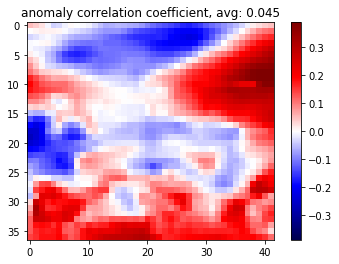

calibration period: 1901 - 1946
test period: 1970 - 2010


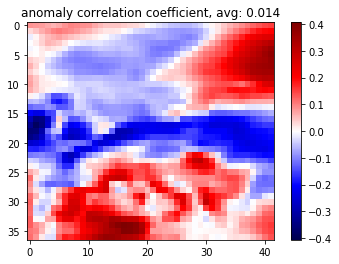

calibration period: 1902 - 1947
test period: 1970 - 2010


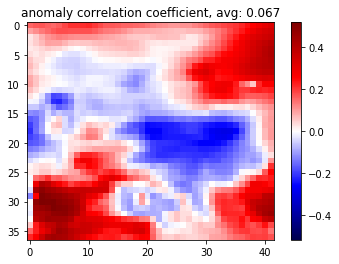

calibration period: 1903 - 1948
test period: 1970 - 2010


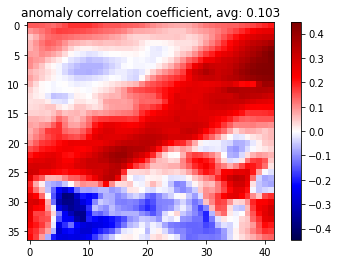

calibration period: 1904 - 1949
test period: 1970 - 2010


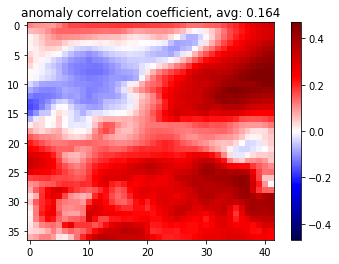

calibration period: 1905 - 1950
test period: 1970 - 2010


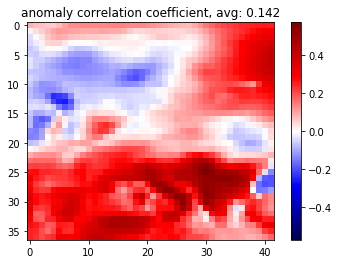

calibration period: 1906 - 1951
test period: 1970 - 2010


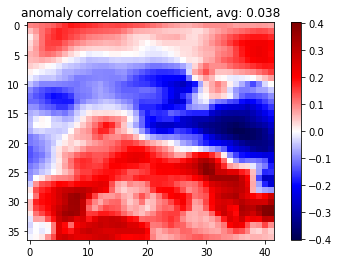

calibration period: 1907 - 1952
test period: 1970 - 2010


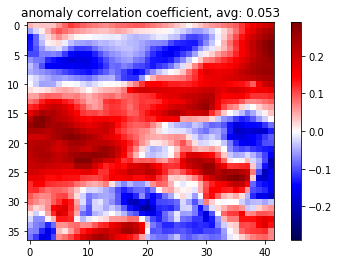

calibration period: 1908 - 1953
test period: 1970 - 2010


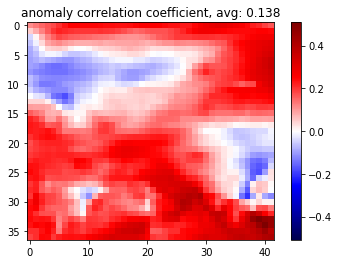

calibration period: 1909 - 1954
test period: 1970 - 2010


In [ ]:
# train an ensemble of models from a sliding window of training years
model_preds, model_targets = [], []
for calibration_offset in range(0,25):
    
    calibration_period = train_years + calibration_offset
    
    print(f'calibration period: {1900+calibration_period[0]} - {1900+calibration_period[-1]}' )
    print(f'test period: {1900+test_years[0]} - {1900+test_years[-1]}' )
    
    idcs = helpers.split_train_data(train_months, test_months, calibration_period, test_years)
    idx_source_train, idx_target_train, idx_source_test, idx_target_test = idcs
    
    anomaly_corrs, params = run_cca(source_data, target_data, n_latents, idcs, if_plot=True, map_shape=map_shape)
    model_preds.append(params['out_pred'])   # grab predictions for later averaging
    model_targets.append(params['out_true']) #

In [ ]:
# compute an ensemble-averaged prediction
from predictability_utils.utils import viz

# test sets should be the same
assert np.all( [np.all(out_true==model_targets[0]) for out_true in model_targets] ) 

# average prediction
mean_pred = np.mean(np.stack(model_preds), axis=0)

anomaly_corrs = helpers.compute_anomaly_corrs(model_targets[0], mean_pred)
viz.visualize_anomaly_corrs(anomaly_corrs.reshape(*map_shape))

In [ ]:
# compare against single model that learns from full training data

calibration_period = np.arange(0, 70) # training period 1900-1969

idcs = helpers.split_train_data(train_months, test_months, calibration_period, test_years)
idx_source_train, idx_target_train, idx_source_test, idx_target_test = idcs

anomaly_corrs, params = run_cca(source_data, target_data, n_latents, idcs, if_plot=True, map_shape=map_shape)


# simple low-rank linear prediction (pixel MSEs) 

- set up simple model $Y = W X$ with $W = U V$
- low-rank: if $Y \in \mathbb{R}^N, X \in \mathbb{R}^M$, then $W \in \mathbb{R}^{N \times M}$, but $U \in \mathbb{R}^{N \times k}, V \in \mathbb{R}^{k \times M}$ with $k << M,N$ !
- low-rank structure saves us parameters: $M N$ parameters in $W$, but only $N k + k M$ in $U$ and $V$, helps prevent overfitting on low samples size

In [ ]:
anomaly_corrs, params = run_lrlin(source_data, target_data, n_latents, idcs, if_plot=True, map_shape=map_shape,
                                 n_epochs=2000, lr=1e-1, batch_size=None)

# debug